# Fundamental diagrams

The nonlinearities inherent in traffic flow are captured by the so-called [fundamental diagrams](https://en.wikipedia.org/wiki/Fundamental_diagram_of_traffic_flow#/media/File:Fundamental_Diagram.PNG). Try to re-make the fundamental diagrams from our data.

In [1]:
using CSV
using DataFrames
using Statistics
using KFactors
using Plots
using RawArray
using CategoricalArrays
using Printf
using RollingFunctions
using StatsBase
using Distributions

In [2]:
data_raw = raread("../data/fundamental_diagram.ra");

In [3]:
data = dropdims(sum(data_raw, dims=4), dims=4);

In [4]:
# define human-readable names for axes
const SPEED = 1
const FLOW = 2
const DENS = 3
const OCC = 4

4

In [5]:
# resample an array to be smaller by averaging adjacent cells
function resample(array, blocksize)
    shp = ceil.(Int64, size(array) ./ blocksize)
    out = zeros(Float64, shp)
    
    for x in 1:shp[1]
        for y in 1:shp[2]
            xfr = (x - 1) * blocksize[1] + 1
            xto = min(x * blocksize[1], size(array)[1])
            yfr = (y - 1) * blocksize[2] + 1
            yto = min(y * blocksize[2], size(array)[2])
            out[x, y] = mean(@view array[xfr:xto, yfr:yto])
        end
    end
    
    out
end

resample (generic function with 1 method)

In [6]:
function toquantiles(vector, n; skipzero=false)
    if skipzero
        qvector = filter(x -> x != 0, reshape(vector, :))
    else
        qvector = reshape(vector, :)
    end
    # n + 1 b/c both 0 and 1 are in range, so 0:0.1:1 is 11 values
    probs = range(0, 1; length=n + 1)
    quantiles = quantile(qvector, probs)
    
    map(x -> probs[findfirst(x .≤ quantiles)], vector)
end

toquantiles (generic function with 1 method)

In [7]:
# insert commas in numbers
# https://stackoverflow.com/questions/52213829
function commas(num::Integer)
    str = string(num)
    return replace(str, r"(?<=[0-9])(?=(?:[0-9]{3})+(?![0-9]))" => ",")
end

commas (generic function with 1 method)

In [8]:
sampsize = sum(data)

5995994378

In [9]:
function normalkernel(arr, scale)
    if scale isa Number
        scale = fill(scale, length(arr))
    end
        
    map(1:length(arr)) do i
        dist = Normal(i, scale[i])
        wgts = pdf.(dist, 1:length(arr))
        sum(arr .* wgts)
    end
end


function getlines(arr;scale=5)
    xs = 1:size(arr)[1]
    
    ys = map(xs) do x
        argmax(arr[x,:])
    end
    
    xs, normalkernel(ys, scale)
end

getlines (generic function with 1 method)

In [10]:
speed_flow = resample(dropdims(sum(data, dims=DENS), dims=DENS), (1, 2))
# Do this as a map from speed to flow due to nonmonotonicity
speed_flow_y, speed_flow_x = getlines(speed_flow)

speed_flow = toquantiles(speed_flow, 30, skipzero=true);

In [11]:
speed_density = resample(dropdims(sum(data, dims=FLOW), dims=FLOW), (3, 2))
# smooth less aggresively at start to avoid averaging in many lower values
speed_density_x, speed_density_y = getlines(transpose(speed_density), scale=vcat(range(0.45, 5, 10), fill(5, 122)))
speed_density = toquantiles(speed_density, 30, skipzero=true);

In [12]:
dens_flow = resample(dropdims(sum(data, dims=SPEED), dims=SPEED), (2, 2))
# smooth not very much early on, so we don't average in too many higher values when we don't
# have lower values in the average
# expand the window and smooth more aggressively as we get to sparser data
# https://xkcd.com/2048/
dens_flow_x, dens_flow_y = getlines(transpose(dens_flow), scale=vcat(1:5, fill(5, 45), range(5, 50, 82)))
dens_flow = toquantiles(dens_flow, 30, skipzero=true);

In [13]:
0:250:2250

0:250:2250

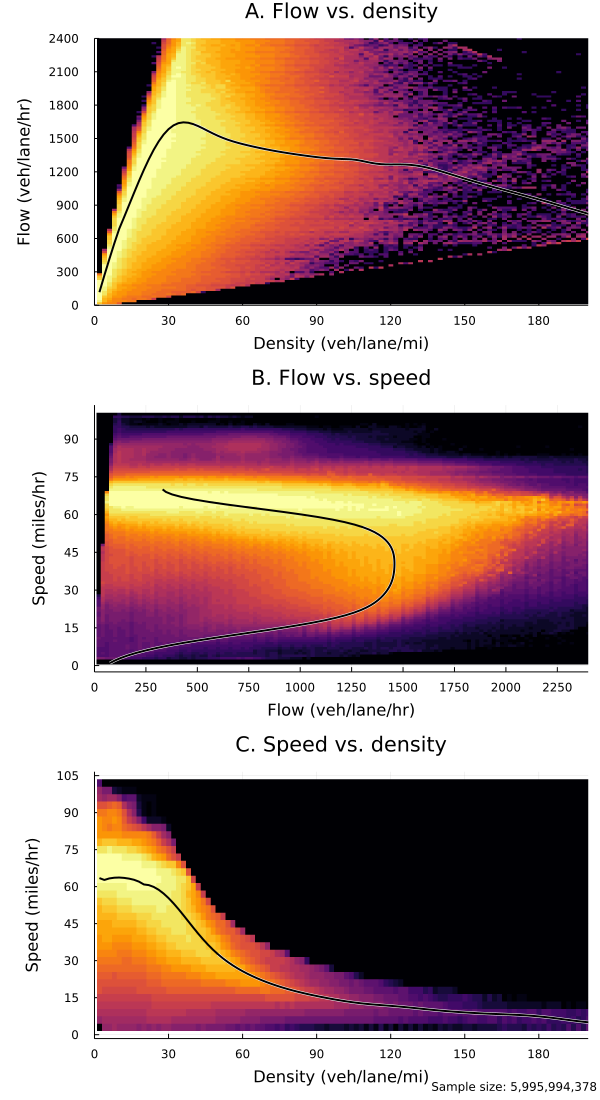

In [14]:
speed_flow_plot = heatmap(speed_flow, yticks=0:15:100, xticks=(0:25//2:115, (0:250:2250)), legend=false)
plot!(speed_flow_x[1:55], speed_flow_y[1:55], color="white", linewidth=3)
plot!(speed_flow_x[1:70], speed_flow_y[1:70], color="black", linewidth=2)
xlims!(speed_flow_plot, 0, 2400 / 20)
ylabel!(speed_flow_plot, "Speed (miles/hr)")
xlabel!(speed_flow_plot, "Flow (veh/lane/hr)")
title!(speed_flow_plot, "B. Flow vs. speed")

speed_dens_plot = heatmap(speed_density, yticks=(0:5:35, (0:5:35) .* 3), xticks=(0:15:90, (0:15:90) .* 2), legend=false)
plot!(speed_density_x[25:end], speed_density_y[25:end], color="white", linewidth=3)
plot!(speed_density_x, speed_density_y, color="black", linewidth=2)
xlabel!(speed_dens_plot, "Density (veh/lane/mi)")
ylabel!(speed_dens_plot, "Speed (miles/hr)")
xlims!(0, 100)
annotate!(speed_dens_plot, 85, -7, text("Sample size: $(commas(sampsize))", pointsize=8))
title!(speed_dens_plot, "C. Speed vs. density")

dens_flow_plot = heatmap(dens_flow, yticks=(0:15:120, (0:15:120) .* 20), xticks=(0:15:90, (0:15:90) .* 2), legend=false)
plot!(dens_flow_x[20:end], dens_flow_y[20:end], color="white", linewidth=3)
plot!(dens_flow_x, dens_flow_y, color="black", linewidth=2)
xlabel!(dens_flow_plot, "Density (veh/lane/mi)")
ylims!(0, 2400/20)
xlims!(0, 100)
ylabel!(dens_flow_plot, "Flow (veh/lane/hr)")
title!(dens_flow_plot, "A. Flow vs. density")

plot(dens_flow_plot, speed_flow_plot, speed_dens_plot, layout=grid(3, 1), size=(600, 1100), left_margin=10Plots.mm)
savefig("../fig/fundamental_diagrams.pdf")
plot!()


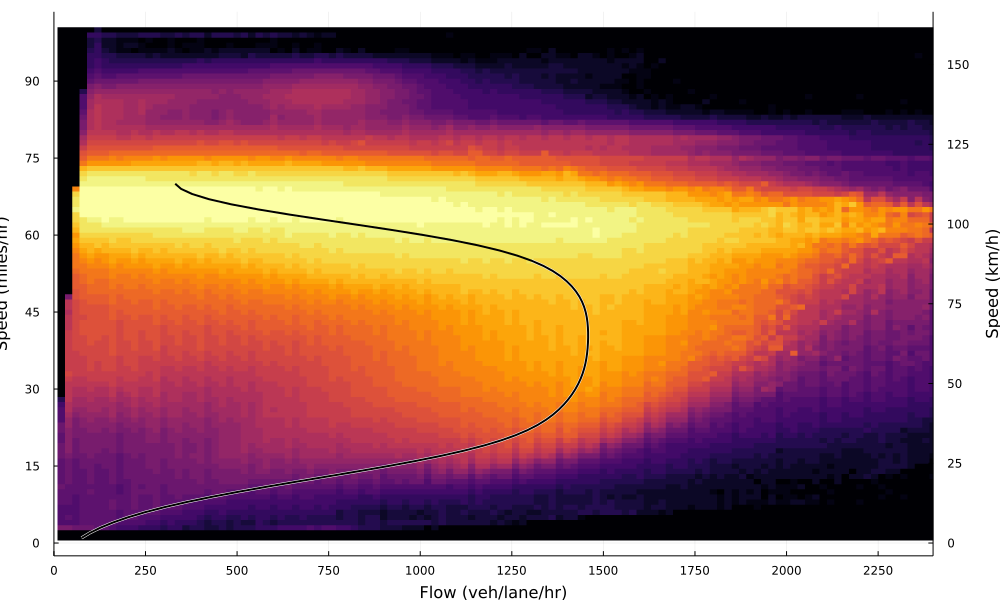

In [19]:
plot(speed_flow_plot, right_margin=15Plots.mm, dpi=300, size=(1000, 600))
title!("")
annotate!(102, -14, text("Sample size: $(commas(sampsize))", pointsize=8))
ax2 = twinx()
plot!(ax2, xticks=false)
ylabel!(ax2, "Speed (km/h)")
yticks!(ax2, 0:25:150)
ylims!(ax2, ylims() .* 1.609)
savefig("../fig/speed_flow_ic2s2.png")
plot!()

In [49]:
?twinx

search: twinx



Adds a new, empty subplot overlayed on top of `sp`, with a mirrored y-axis and linked x-axis.


In [38]:
ylims()

(-2.5, 103.5)

# Plot speed vs. occupancy to see when congestion occurs

In [15]:
speedocc = dropdims(sum(data_raw, dims=(FLOW, DENS)), dims=(FLOW, DENS))

100×220 Matrix{Int64}:
   0    0    0    0    0     0     0  …     0     0     0     0     0     0
   0    0    0    0    0     0     0        0     0     0     0     0     0
 256  405  460  357  261   208   193       80   133   117   103    92   100
  43   62   51   65   52    60    42       86   106   115   109    99   112
  45   41   44   54   54   215    33      133   162   145   140   149   175
  47   49   36   43   50    52    98  …   187   226   202   178   177   225
  33   49   42   39   52    43    63      263   258   223   253   255   266
  36   81   75   71   58    79    62      363   352   357   373   350   378
  43  178   84   84  110    86    80      476   519   519   587   553   507
 162  262  152  130  176    98    87      786   794   835   804   830   901
 222  171  153  190  168   108   110  …  1271  1133  1243  1317  1288  1290
 207  203  220  305  156   104   224     1642  1790  1746  1786  1917  1804
 157  125  140  137  173   103   127     2374  2430  2511  2592  

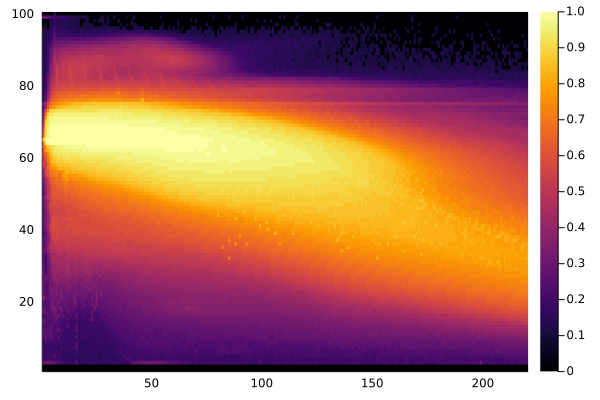

In [23]:
heatmap(toquantiles(speedocc, 50))